In [5]:
import numpy as np
import torch
import nibabel as nib
import matplotlib.pyplot as plt
from bratsreg_model_stage import (
    SpatialTransform_unit, SpatialTransformNearest_unit,
)
from Functions import save_img



In [32]:
use_cuda=False
device = torch.device("cuda" if use_cuda else "cpu")
#transform = SpatialTransform_unit().to(device)
transform = SpatialTransformNearest_unit().to(device)

F_X_Y_file="../Dataset/test/BraTSReg_001/1F_X_Y.nii.gz"
F_Y_X_file="../Dataset/test/BraTSReg_001/1F_Y_X.nii.gz"
grid_unit_file="../Dataset/test/BraTSReg_001/1grid_unit.nii.gz"
seg_image_file="../Dataset/test/BraTSReg_001/01.npy"

# labels
seg_out = np.load(seg_image_file)
seg_out = torch.from_numpy(seg_out).to(device)
seg_out = seg_out.unsqueeze(0).unsqueeze(1)
print(seg_out.shape)

template = nib.load(F_X_Y_file)
header, affine = template.header, template.affine


# Matriz de transformacion
F_X_Y = torch.from_numpy(nib.load(F_X_Y_file).get_fdata()).to(device)
F_X_Y = F_X_Y.unsqueeze(0)

F_Y_X = torch.from_numpy(nib.load(F_Y_X_file).get_fdata()).to(device)
F_Y_X = F_Y_X.unsqueeze(0)
grid_unit = torch.from_numpy(nib.load(grid_unit_file).get_fdata()).to(device)
grid_unit = grid_unit.unsqueeze(0)
print(F_X_Y.shape, F_Y_X.shape, grid_unit.shape)

warped_seg = transform(seg_out, F_X_Y.permute(0, 2, 3, 4, 1), grid_unit)

save_img(
                warped_seg.cpu().numpy()[0],
                f"../Dataset/test/BraTSReg_001/segmentation.nii.gz",
                header,
                affine,
            )


torch.Size([1, 1, 240, 240, 155])
torch.Size([1, 3, 240, 240, 155]) torch.Size([1, 3, 240, 240, 155]) torch.Size([1, 240, 240, 155, 3])


In [7]:
def display_slice(slice_data, title=None):
  plt.imshow(slice_data.squeeze(), cmap='gray')  # Squeeze to remove channel dim if present
  plt.colorbar()
  if title:
    plt.title(title)
  plt.show()

def display_slice_with_segmentation(mri_slice, segmentation_slice, title=None):
    plt.imshow(mri_slice.squeeze(), cmap='gray')  # Squeeze to remove channel dim if present
    plt.imshow(segmentation_slice.squeeze(), cmap='jet', alpha=0.3)  # Overlay segmentation with transparency
    plt.colorbar()
    if title:
        plt.title(title)
    plt.show()

torch.Size([1, 1, 240, 240, 155])


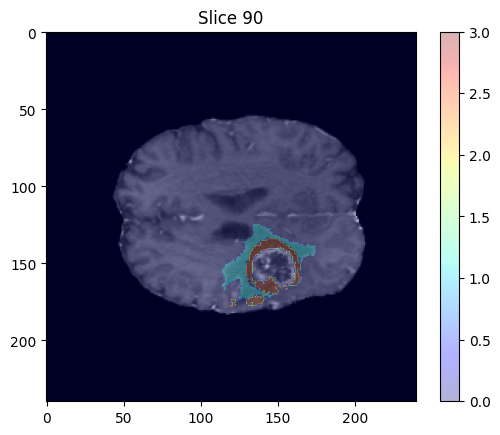

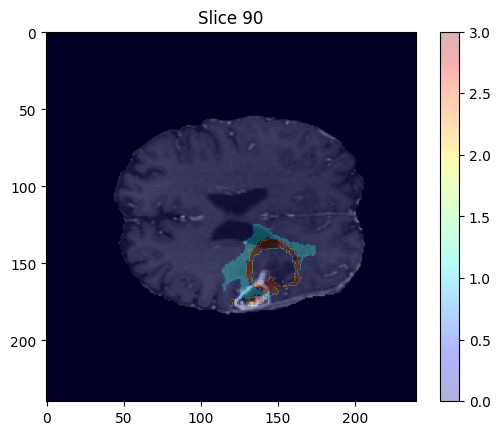

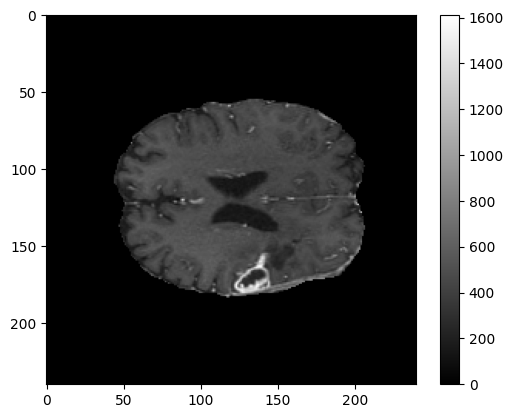

In [37]:
# Plot warped_seg using matplotlib
print(warped_seg.shape)

slice_num = 90
selected_slice_w = warped_seg[0, 0, :, :, slice_num]

MRI= nib.load("../Dataset/test/BraTSReg_001/1_X_Y.nii.gz").get_fdata()
selected_slice_MRI = MRI[:, :, slice_num]
display_slice_with_segmentation(selected_slice_MRI, selected_slice_w, title=f"Slice {slice_num}")

MRI_R= nib.load("../Dataset/test/BraTSReg_001/UPENN-GBM-00036_21_T1GD.nii.gz").get_fdata()
selected_slice_MRI_R = MRI_R[:, :, slice_num]
display_slice_with_segmentation(selected_slice_MRI_R, selected_slice_w, title=f"Slice {slice_num}")

display_slice(selected_slice_MRI_R, title=None)

In [1]:
import glob
import torch.utils.data as Data
#from Functions import Validation_Brats

datapath='../Dataset/test'

val_fixed_list = sorted(glob.glob(f"{datapath}/BraTSReg_*/*_0000_t1ce.nii.gz"))
val_moving_list = sorted(glob.glob(f"{datapath}/BraTSReg_*/*_t1ce.nii.gz"))
val_moving_list = sorted([path for path in val_moving_list if path not in val_fixed_list])

val_fixed_csv_list = sorted(glob.glob(f"{datapath}/BraTSReg_*/*_0000_landmarks.csv"))
val_moving_csv_list = sorted(glob.glob(f"{datapath}/BraTSReg_*/*_landmarks.csv"))
val_moving_csv_list = sorted([path for path in val_moving_csv_list if path not in val_fixed_csv_list])

# valid_generator = Data.DataLoader(Validation_Brats(val_fixed_list, val_moving_list, val_fixed_csv_list,
#                                                       val_moving_csv_list, norm=True), batch_size=1,
#                                       shuffle=False, num_workers=2)

In [2]:
print(val_fixed_list)
print(val_moving_list)

['../Dataset/test\\BraTSReg_002\\BraTSReg_002_00_0000_t1ce.nii.gz']
['../Dataset/test\\BraTSReg_002\\BraTSReg_002_01_0262_t1ce.nii.gz']


In [19]:
# Rutas de archivos CSV de landmarks fijos
def get_paths_data(datapath):
    fixed_landmarks_csv_list = sorted(glob.glob(f"{datapath}/BraTSReg_*_0000_landmarks.csv"))
    moving_landmarks_csv_list = sorted(glob.glob(f"{datapath}/BraTSReg_*_0262_landmarks.csv"))

    # Rutas de archivos de imágenes T1GD fijas y móviles
    fixed_t1ce_list = sorted(glob.glob(f"{datapath}/*/UPENN-GBM-*_11*_T1GD.nii.gz"))
    moving_t1ce_list = sorted(glob.glob(f"{datapath}/*/UPENN-GBM-*_21*_T1GD.nii.gz"))

    # Rutas de archivos de imágenes T2 fijas y móviles
    fixed_t2_list = sorted(glob.glob(f"{datapath}/*/UPENN-GBM-*_11*_T2.nii.gz"))
    moving_t2_list = sorted(glob.glob(f"{datapath}/*/UPENN-GBM-*_21*_T2.nii.gz"))

    # Repetir fixed_landmarks_csv_list para que tenga el tamaño de fixed_t1ce_list
    fixed_landmarks_csv_list = fixed_landmarks_csv_list * len(fixed_t1ce_list)
    moving_landmarks_csv_list = moving_landmarks_csv_list * len(fixed_t1ce_list)
    
    return fixed_landmarks_csv_list, moving_landmarks_csv_list, fixed_t1ce_list, moving_t1ce_list, fixed_t2_list, moving_t2_list

In [1]:
from load_data import get_paths_data
datapath='../Dataset/test'
fixed_landmarks_csv_list, moving_landmarks_csv_list, fixed_t1ce_list, moving_t1ce_list, fixed_t2_list, moving_t2_list=get_paths_data(datapath)
print(fixed_landmarks_csv_list )
print(moving_landmarks_csv_list )

print(fixed_t1ce_list)
print(moving_t1ce_list)
print(fixed_t2_list)
print(moving_t2_list)

['../Dataset/test\\BraTSReg_002_00_0000_landmarks.csv', '../Dataset/test\\BraTSReg_002_00_0000_landmarks.csv', '../Dataset/test\\BraTSReg_002_00_0000_landmarks.csv', '../Dataset/test\\BraTSReg_002_00_0000_landmarks.csv']
['../Dataset/test\\BraTSReg_002_01_0262_landmarks.csv', '../Dataset/test\\BraTSReg_002_01_0262_landmarks.csv', '../Dataset/test\\BraTSReg_002_01_0262_landmarks.csv', '../Dataset/test\\BraTSReg_002_01_0262_landmarks.csv']
['../Dataset/test\\UPENN-GBM-00036_11\\UPENN-GBM-00036_11_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00042_11\\UPENN-GBM-00042_11_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00045_11\\UPENN-GBM-00045_11_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00051_11\\UPENN-GBM-00051_11_T1GD.nii.gz']
['../Dataset/test\\UPENN-GBM-00036_21\\UPENN-GBM-00036_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00042_21\\UPENN-GBM-00042_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00045_21\\UPENN-GBM-00045_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00051_21\\UPENN-GBM-00051_21_T1